In [1]:
import sys
import numpy as np

sys.path.extend(['./../lib', './../lib/models', './../helpers'])
from model import Model
from solver import Solver
from solvers_check import SolversCheck
from helpers import init_jupyter

init_jupyter()

Start |  3:26PM MSK on Sep 23, 2019 |
-------------------------------------


In [ ]:
MD = Model('fpe_3d_drift_zero')
MD.init(s=1., D=0.5)
MD.info()

In [2]:
SL = Solver(model=MD)
SL.set_grid_t(10, 0., 1., t_hst=10)
SL.set_grid_x(21, -5., 5.)
SL.prep()
SL.calc()
SL.info()

Solve: 100%|█| 9/9 [00:09<00:00,  1.02s/step, | At T=1.0e+00 : er=3.8e-03 es=1.3e-01]

----------- Solver
Format    : 3D, NP [order=2]
Grid t    : poi =        10, min =    0.0000, max =    1.0000
Grid x    : poi =        21, min =   -5.0000, max =    5.0000
Time sec  : prep = 2.90e+00, calc = 9.06e+00, spec = 7.30e-02
Err real  : 3.76e-03
Err stat  : 1.32e-01


In [ ]:
opts = { 'is_log': False, 'is_abs': False, 'is_err_abs': False, 'with_err_stat': False }
SL.plot_t([-2.5]*3, opts)
SL.plot_t([+0.0]*3, opts)
SL.plot_t([+2.5]*3, opts)

In [ ]:
opts = { 'is_log': False, 'is_abs': False, 'is_err_abs': False, 'with_err_stat': False }
SL.plot_x(+0.1, opts)
SL.plot_x(+0.5, opts)
SL.plot_x(None, opts)

<div class="head1">
    <div class="head1__name">
        Results for multiple computations
    </div>
    <div class="head1__note">
        We use results that already saved to file (see file `multi_solve.ipynb`).
    </div>
</div>

In [8]:
SLC = SolversCheck('./../computations/data/fpe_3d_drift_zero')
SLC.load()

name1 = 'Solver-NP'
name2 = 'Solver-TT'

M = SLC.res[name2]['M']
N = SLC.res[name2]['N']

m = M[-1]
n = N[-1]

<div class="head2">
    <div class="head2__name">
        Dependence on the number of time points
    </div>
    <div class="head2__note">
        We present results for TT-solver of the 2th order.
    </div>
</div>

In [ ]:
SLC.plot(name2, n=n, is_stat=False, is_xpoi=False, lims={ 'all': [1, None] })

<div class="head2">
    <div class="head2__name">
        Dependence on the number of spatial points
    </div>
    <div class="head2__note">
        We present results for TT-solver of the 2th order.
    </div>
</div>

In [ ]:
SLC.plot(name2, m=m, is_stat=False, is_xpoi=False, lims={ 'all': [1, 6] })

<div class="head2">
    <div class="head2__name">
        Dependence on the solver type
    </div>
    <div class="head2__note">
        We present results (dependencies on the number of time and spatial points) for NP-solver and TT-solver.
    </div>
</div>

In [ ]:
SLC.plot_all(n=SLC.res[name1]['N'][-1], is_stat=False, is_xpoi=False)

In [ ]:
SLC.plot_all(m=SLC.res[name1]['M'][-1], is_stat=False, is_xpoi=False)

<div class="head1">
    <div class="head1__name">
        DRAFT | Explicit (simple) solvers
    </div>
    <div class="head1__note">
        Only for example and tests.
    </div>
</div>

In [8]:
import time
import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

from intertrain import Intertrain

In [9]:
d = 3
m = t_poi
n = x_poi
l = (x_max - x_min) / (x_poi - 1)
h = (t_max - t_min) / (t_poi - 1)
T = np.linspace(t_min, t_max, t_poi)

I0 = np.eye(n)
J0 = np.eye(n); J0[0, 0] = 0.; J0[-1, -1] = 0. 

J = np.kron(J0, np.kron(J0, J0))

In [10]:
def show_x(X, r_calc, _time):
    X = X.reshape(d, -1)
    r_init = func_r0(X)
    r_real = func_rt(X, t_max)
    r_stat = func_rs(X)
    e = np.linalg.norm(r_real - r_calc) / np.linalg.norm(r_real)
    X = np.arange(X.shape[1])
    
    print('Number of spatial points : %8d^%d'%(x_poi, d))
    print('Number of time points    : %8d'%t_poi)
    print('Error (relative norm)    : %-12.2e'%e)
    print('Total time (sec)         : %-12.2e'%_time)
    print()
    
    plt.plot(
        X.reshape(-1), r_init, '--', label='Initial',
        linewidth=3, color='tab:blue'
    )
    plt.plot(
        X, r_calc, label='Calculated',
        linewidth=1, color='tab:green', marker='o', markersize=7,
        markerfacecolor='lightgreen', markeredgecolor='g'
    )
    plt.plot(
        X, r_real, label='Analytic',
        linewidth=3, color='black'
    )
    plt.plot(
        X, r_stat, '--', label='Stationary',
        linewidth=2, color='magenta'
    )
    
    plt.title('Solution at the final time step')
    plt.xlabel('Point number')
    plt.ylabel('r')
    plt.legend(loc='best')
    plt.show()

    err = np.abs(r_real - r_calc) / np.abs(r_real)
    plt.plot(
        X, err, label='Analytic',
        linewidth=3, color='black'
    )
    plt.semilogy()
    plt.title('Solution error at the final time step')
    plt.xlabel('Point number')
    
    plt.show()

<div class="head2">
    <div class="head2__name">
        Uniform spatial grid and the forward Euler scheme
    </div>
</div>

We can solve equation on the uniform spatial grid for the time $t > 0$ using standard forward Euler scheme
$$
    r_{k+1} = r_{k} + h D r_{k},
    \quad
    k = 0, 1, \ldots, m-1,
$$
where
$$
    D =
        D_0 \otimes I   \otimes I +
        I   \otimes D_0 \otimes I +
        I   \otimes I   \otimes D_0,
$$
$$
    D_0 = \frac{D_{coef}}{l^2} tridiag \left( 1, -2, 1 \right).
$$

Number of spatial points :       15^3
Number of time points    :      100
Error (relative norm)    : 9.35e-04    
Total time (sec)         : 4.36e+00    



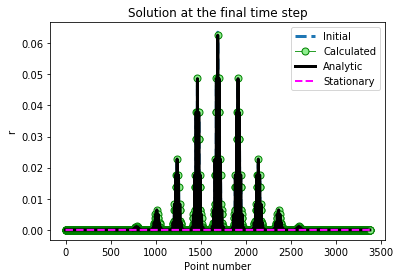

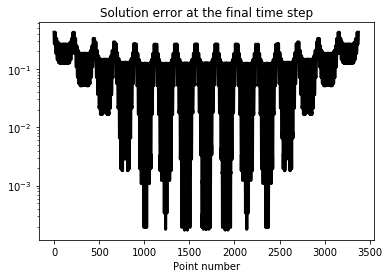

In [11]:
_time = time.time()



X = np.linspace(x_min, x_max, x_poi).reshape(1, -1)
X = [X.copy() for _ in range(d)]
X = np.meshgrid(*X, indexing='ij')
X = np.array(X).reshape((d, -1), order='F')
    
D0 = sp.spdiags([
        [+1.] * x_poi,
        [-2.] * x_poi,
        [+1.] * x_poi
    ], [-1, 0, 1], x_poi, x_poi
).tocsr().toarray()
D0 = D0 * D_coef / l / l

D = np.zeros((n**d, n**d))
for i in range(d):
    M = [I0] * d; M[i] = D0
    Q = M[0].copy()
    for j in range(1, d):
        Q = np.kron(Q, M[j])
    D+= Q

r = func_r0(X)
for t in T[1:]:
    r = r + h * D @ r

show_x(X, r, time.time() - _time)

<div class="head2">
    <div class="head2__name">
        Chebyshev spatial grid and the matrix exponential
    </div>
</div>

We have
$$
    \frac{\partial r}{\partial t} = D_{coef} \nabla r
$$
or
$$
    \frac{\partial r}{\partial t} = J Z J r,
$$
$$
    J = J_0 \otimes I \otimes I + I \otimes J_0 \otimes I + I \otimes I \otimes J_0,
$$
$$
    Z =
        D_{coef} \cdot
        \left( D \otimes I \otimes I + I \otimes D \otimes I + I \otimes I \otimes D \right),
$$
where $D$ is the 2th order Chebyshev differentiation matrix.

We can solve equation on the Chebyshev spatial grid for the time $t > 0$ using matrix exponential and the 2th order Chebyshev differentiation matrix
$$
    u_{t} = e^{t \cdot D_{coef} \cdot D} u_{0},
$$
where $u_{0}(x)$ is the known initial condition and diffusion matrix is defined as above.



Number of spatial points :       15^3
Number of time points    :      100
Error (relative norm)    : 9.63e-03    
Total time (sec)         : 1.31e+01    



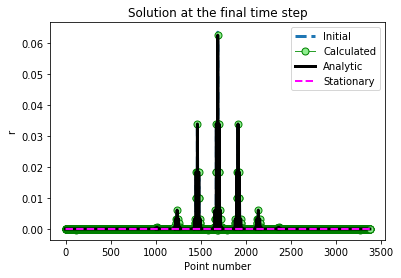

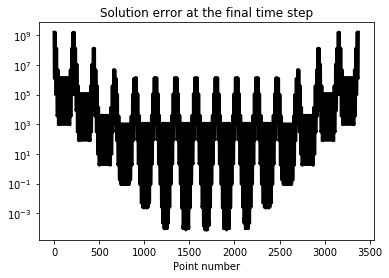

In [12]:
_time = time.time()

IT = Intertrain(n=[x_poi, x_poi, x_poi], l=[[x_min, x_max], [x_min, x_max], [x_min, x_max]])

X = IT.grid()

D0 = IT.dif2() * D_coef

D = np.zeros((n**d, n**d))
for i in range(d):
    M = [I0] * d; M[i] = D0
    Q = M[0].copy()
    for j in range(1, d):
        Q = np.kron(Q, M[j])
    D+= Q

Z = expm((t_max - t_min) * D)

r = func_r0(X)
r = Z @ r

Z1 = Z
show_x(X, r, time.time() - _time)

Number of spatial points :       15^3
Number of time points    :      100
Error (relative norm)    : 9.63e-03    
Total time (sec)         : 1.39e-01    



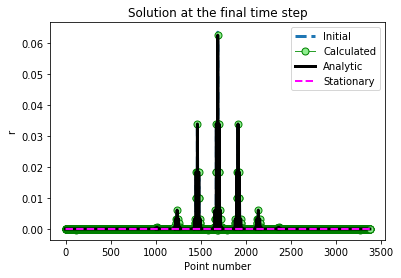

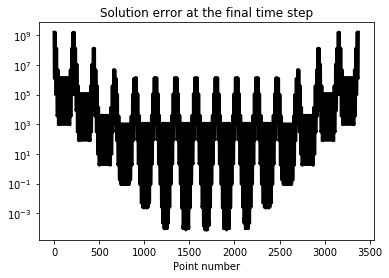

In [13]:
_time = time.time()

IT = Intertrain(n=[x_poi, x_poi, x_poi], l=[[x_min, x_max], [x_min, x_max], [x_min, x_max]])

X = IT.grid()

D0 = IT.dif2() * D_coef

Z0 = expm((t_max - t_min) * D0)

Z = Z0.copy()
for _ in range(1, d): Z = np.kron(Z, Z0)

r = func_r0(X)
r = Z @ r

Z2 = Z
show_x(X, r, time.time() - _time)

<div class="head1">
    <div class="head1__name">
        Multiple computations
    </div>
    <div class="head1__note">
        We compute dependencies of solution accuracy and calculation time on the number of time and spacial points and solver type. Results are saved to file and may be reused later for visualization.  
    </div>
</div>

In [ ]:
if False: # Protection of already saved data
    SLC = SolversCheck(data_path)
    SLC.set_grid_t(t_min, t_max)
    SLC.set_grid_x(x_min, x_max)
    SLC.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
    SLC.set_coefs(D_coef)

    M = [10, 100, 1000]
    N = list(np.arange(5, 16, 5, dtype=int))
    SLC.add(name='Solver-NP', d=3, eps=1.E-6, ord=2, with_tt=False, M=M, N=N)

    M = [10, 100, 1000, 10000]
    N = list(np.arange(5, 26, 5, dtype=int))
    SLC.add(name='Solver-TT', d=3, eps=1.E-6, ord=2, with_tt=True, M=M, N=N)

    SLC.calc()
    SLC.save()

<div class="end"></div>